In [1]:
# Cell 1
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

2024-07-11 16:06:46.858551: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 16:06:46.858717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 16:06:47.028839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Cell 2
# Define directories
cracked_dir = '/kaggle/input/decksbridge1/Decks/Cracked'
non_cracked_dir = '/kaggle/input/decksbridge1/Decks/Non-cracked'

# Define image size
image_size = (128, 128)

# Function to load images and labels
def load_images_from_folder(folder, label, image_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            images.append(img)
            labels.append(label)
    return images, labels

# Load images and labels
cracked_images, cracked_labels = load_images_from_folder(cracked_dir, 1, image_size)
non_cracked_images, non_cracked_labels = load_images_from_folder(non_cracked_dir, 0, image_size)

# Combine cracked and non-cracked images and labels
images = np.array(cracked_images + non_cracked_images)
labels = np.array(cracked_labels + non_cracked_labels)

# Normalize images
images = images / 255.0

# Shuffle the data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Split into training, validation, and test sets
train_size = int(0.7 * len(images))
val_size = int(0.15 * len(images))
test_size = len(images) - train_size - val_size

train_images, train_labels = images[:train_size], labels[:train_size]
val_images, val_labels = images[train_size:train_size+val_size], labels[train_size:train_size+val_size]
test_images, test_labels = images[train_size+val_size:], labels[train_size+val_size:]

In [3]:
# Cell 3
# Create ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/decksbridge1/Decks/',
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 13620 images belonging to 2 classes.


In [4]:
# Cell 4
# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# Use .repeat() to ensure the dataset has enough batches
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).repeat()
val_dataset = val_dataset.batch(32).repeat()

In [5]:
# Cell 5
# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Cell 6
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_images.shape[0] // 32
validation_steps = val_images.shape[0] // 32

# Training the model
history = model.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 160s 525ms/step - accuracy: 0.8411 - loss: 0.4791 - val_accuracy: 0.8730 - val_loss: 0.3827
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 155s 521ms/step - accuracy: 0.8475 - loss: 0.4442 - val_accuracy: 0.8717 - val_loss: 0.3817
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 156s 527ms/step - accuracy: 0.8449 - loss: 0.4457 - val_accuracy: 0.8717 - val_loss: 0.3862
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 173s 583ms/step - accuracy: 0.8510 - loss: 0.4317 - val_accuracy: 0.8712 - val_loss: 0.3830
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 157s 528ms/step - accuracy: 0.8447 - loss: 0.4398 - val_accuracy: 0.8727 - val_loss: 0.3766
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 150s 506ms/step - accuracy: 0.8499 - loss: 0.4264 - val_accuracy: 0.8717 - val_loss: 0.3721
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 151s 507ms/step - accuracy: 0.8509 - loss: 0.4076 - val_accuracy: 0.8722 - val_loss: 0.3560
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 162s 546ms/step - accuracy: 0.8492 -

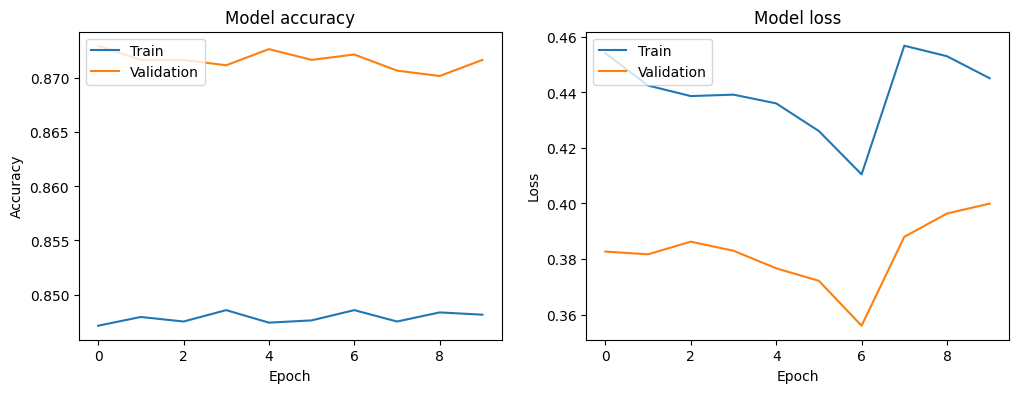

In [7]:
# Cell 7
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [8]:
# Cell 8
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


425/425 ━━━━━━━━━━━━━━━━━━━━ 66s 155ms/step - accuracy: 0.4308 - loss: 1.1689
Test Accuracy: 14.89%


In [9]:
# Cell 9
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [10]:
# Cell 10
# Define the image paths
image_paths = [
    '/kaggle/input/decksbridge1/Decks/Cracked/7001-115.jpg',
    '/kaggle/input/decksbridge1/Decks/Cracked/7004-62.jpg',
    '/kaggle/input/decksbridge1/Decks/Cracked/7006-77.jpg',
    '/kaggle/input/decksbridge1/Decks/Cracked/7009-30.jpg',
    '/kaggle/input/decksbridge1/Decks/Non-cracked/7001-125.jpg',
    '/kaggle/input/decksbridge1/Decks/Cracked/7008-57.jpg',
    '/kaggle/input/decksbridge1/Decks/Cracked/7002-152.jpg',
    '/kaggle/input/decksbridge1/Decks/Cracked/7002-216.jpg',
    '/kaggle/input/decksbridge1/Decks/Cracked/7006-133.jpg',
    '/kaggle/input/decksbridge1/Decks/Non-cracked/7001-113.jpg'
]

# Load and preprocess the images
images = []
for path in image_paths:
    image = load_img(path, target_size=(128, 128))  # Resize to match the input size
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    images.append(image)

# Stack the images for prediction
images = np.vstack(images)
images = images / 255.0  # Rescale

In [11]:
# Cell 11
# Generate predictions
predictions = model.predict(images)
print(predictions)
predicted_labels = (predictions > 0.4).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[[0.2020195 ]
 [0.20162232]
 [0.20482   ]
 [0.20465444]
 [0.20986715]
 [0.20460476]
 [0.20183475]
 [0.20795287]
 [0.20641194]
 [0.20347735]]


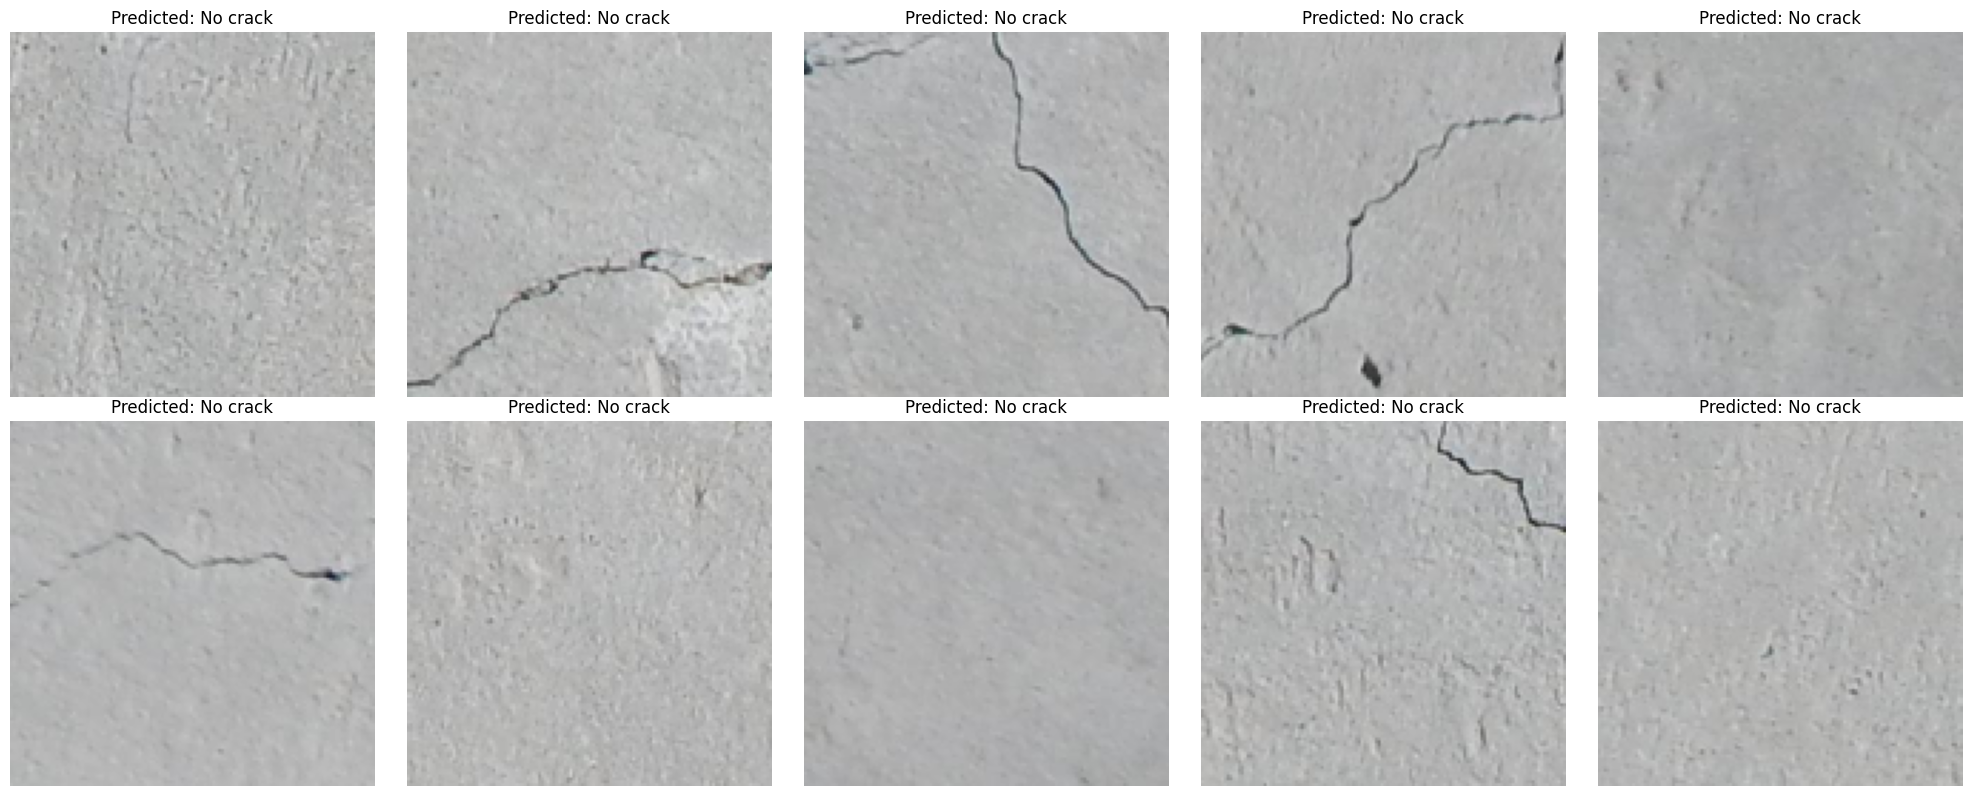

In [12]:
# Cell 12
# Define a function to draw bounding boxes on images
def draw_bounding_box(image, label):
    if label == 1:  # If a crack is detected
        # Convert to grayscale and find contours
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, threshold1=30, threshold2=100)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w * h > 500:  # Filter out small boxes
                cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    return image

# Display the images with bounding boxes
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows and 5 columns
axes = axes.flatten()

for i, path in enumerate(image_paths):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (128, 128))  # Resize to match the input size
    image = draw_bounding_box(image, predicted_labels[i])
    axes[i]. imshow(image)
    axes[i].set_title(f'Predicted: {"Crack" if predicted_labels[i] == 1 else "No crack"}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
   